<a href="https://colab.research.google.com/github/Calcifer777/learn-rl/blob/main/03_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash

apt install -q xvfb python-opengl ffmpeg

In [2]:
!pip install -q gymnasium renderlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 30.3 MB/s eta 0:00:00


In [3]:
from datetime import datetime
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import yaml
import renderlab
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [6]:
class Memory:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class Policy(nn.Module):

    def __init__(self, dim_inputs, dim_outputs, dim_hidden=128):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(dim_inputs, dim_hidden)
        self.layer2 = nn.Linear(dim_hidden, dim_hidden)
        self.layer3 = nn.Linear(dim_hidden, dim_outputs)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [8]:
%%bash

echo """
BATCH_SIZE: 128  # num transitions sampled from the replay buffer
GAMMA: 0.99  # discount factor
EPS_START: 0.9  # starting value of exploration rate
EPS_END: 0.05  # ending value of exploration rate
EPS_DECAY: 1000  # exploration rate decay
TAU: 0.005  # target network update rate
LR: 0.001  # DQN optimizer learning rate
""" > params.yaml

In [9]:
with open("params.yaml", "r") as fp:
  params = yaml.safe_load(fp)

In [10]:
def get_expl_rate(steps_done, start, end, decay):
  return end + (start - end) * math.exp(-1. * steps_done / decay)

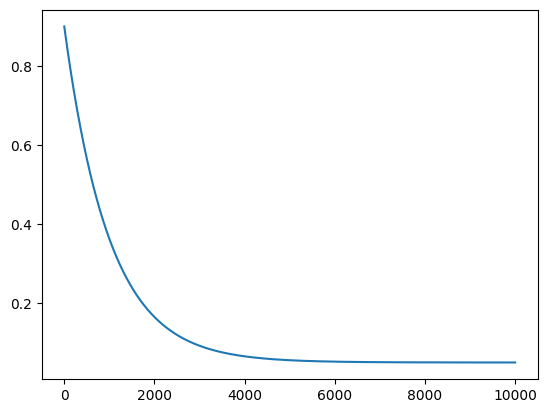

In [23]:
x = range(10000)
y = [get_expl_rate(i, params["EPS_START"], params["EPS_END"], params["EPS_DECAY"]) for i in x]

plt.plot(x, y)
plt.show()

In [11]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [12]:
def select_action(state, env, expl_rate, policy_net):
    sample = random.random()
    if sample > expl_rate:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            values, indices = policy_net(state).max(1)
            return indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [13]:
def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [14]:
def optimize_model(policy, target_policy, memory, batch_size, gamma, optimizer, loss_fn):
    if len(memory) < batch_size:
      return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
      tuple(map(lambda s: s is not None, batch.next_state)), 
      device=device, 
      dtype=torch.bool
    )
    non_final_next_states = torch.cat(
      [s for s in batch.next_state if s is not None]
    )
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    q_pred = policy(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_policy(non_final_next_states).max(1)[0]
    
    # Compute the expected Q values
    q_target = reward_batch + (next_state_values * gamma)

    # Compute Huber loss 
    loss = loss_fn(q_pred, q_target.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy.parameters(), 100)
    optimizer.step()

In [15]:
NUM_INPUTS = env.observation_space.shape[0]
NUM_OUTPUTS = env.action_space.n

In [16]:
def interpolate_policy(target, updated, rate, inplace=False):
  # Soft update of the target network's weights
  # θ′ ← τ θ + (1 −τ )θ′
  target_state = target.state_dict()
  new_state = updated.state_dict()
  for key in new_state:
    target_state[key] = new_state[key]*rate + target_state[key]*(1-rate)
  if inplace:
    target.load_state_dict(target_state)
  return target_state

In [17]:
num_episodes = 600 if torch.cuda.is_available() else 250
memory = Memory(capacity=10000)
episode_durations = list()

policy = Policy(NUM_INPUTS, NUM_OUTPUTS).to(device)
policy_target = Policy(NUM_INPUTS, NUM_OUTPUTS).to(device)

optimizer = optim.AdamW(policy.parameters(), lr=params["LR"], amsgrad=True)
loss_fn = nn.SmoothL1Loss()

steps_done = 0

In [18]:
for i_episode in tqdm(range(num_episodes)):
  # Initialize the environment and get it's state
  state, info = env.reset()
  state = torch.tensor(state, device=device).unsqueeze(0)
  for t in count():
    expl_rate = get_expl_rate(steps_done, params["EPS_START"], params["EPS_END"], params["EPS_DECAY"])
    action = select_action(state, env, expl_rate, policy)
    steps_done +=1
    
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    next_state = None if terminated else torch.tensor(observation, device=device).unsqueeze(0)
    
    # Store the transition in memory
    memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the policy network)
    optimize_model(policy, policy_target, memory, params["BATCH_SIZE"], params["GAMMA"], optimizer, loss_fn)

    # Soft update of the target network's weights:  θ′ ← τ θ + (1 −τ) θ′
    new_target_params = interpolate_policy(policy_target, policy, params["TAU"])
    policy_target.load_state_dict(new_target_params)

    if done:
      episode_durations.append(t + 1)
      break

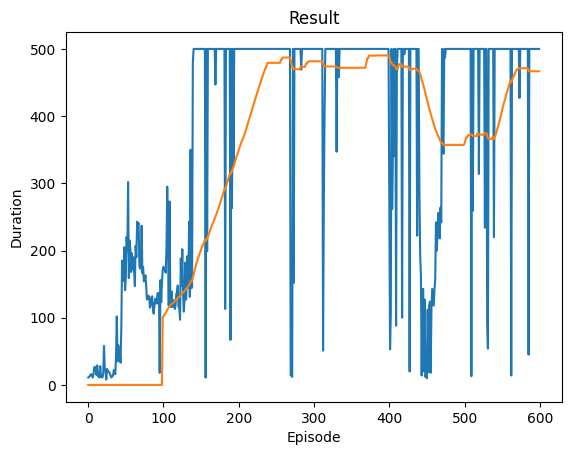

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
plot_durations(episode_durations, show_result=True)
plt.ioff()
plt.show()

In [19]:
# ts = datetime.utcnow().isoformat()
# env_rendered = renderlab.RenderFrame(env, directory=f"./dqn-{ts}")
# run_episode(env_rendered, policy)
# env_rendered.play()